<a href="https://colab.research.google.com/github/atolia/Colabs/blob/main/Basic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [16]:
try:
  import yfinance as yf
  import mibian
except Exception:
  !pip install yfinance > /dev/null 2>&1
  !pip install mibian >/dev/null
  import yfinance as yf
  import mibian
import pandas as pd
from google.colab import data_table
from datetime import datetime
import math
import numpy as np
# from types import SimpleNamespace
from IPython.display import Markdown, display, Javascript

def printmd(string):
    display(Markdown(string))

date_format = "%Y-%m-%d"

#@title Enter symbol and click Runtime->Run all. Options data from Yahoo finance usually available after 9:30AM EST { vertical-output: true, display-mode: "form" }
symbol = "AAPL" #@param {type:"string"}
ticker = yf.Ticker(symbol) 
distanceStrike =   8#@param {type:"integer"}
distanceDate =   6#@param {type:"integer"}
commissionUSD = 1.5 #@param {type:"number"}
deltaLimit = 0.3 #@param {type:"number"}
hist1y = ticker.history(period='1y')
# ' '.join([prop for prop in ticker.info ])

def showPUTs(ticker, deltaLimit=-0.3 ):
  final = [];
  tdPrc = ticker.info['regularMarketPrice']
  ytdPrc = ticker.info['regularMarketPreviousClose']
  diff= (tdPrc-ytdPrc)/ytdPrc*100
  interest_rate = 0
  colsArr = [ 'days', 'Strike', 'today Change%', 'Profit $', '$/day', 'Profit %', 'Profit 1Y %', 'IV', 'OI', 'Delta', 'DualDelta', 'Gamma']
  for j in range(0, min(distanceDate, len(ticker.options)-1)):
    out = [];
    opdtstr = ticker.options[j]
    puts = ticker.option_chain(opdtstr).puts
    inMndx1 = puts.loc[puts['inTheMoney'] == True].index
    if len(inMndx1)>0:
      inMndx = inMndx1[0] 
    if inMndx < 1:
      continue
    opdt = datetime.strptime(opdtstr, date_format)
    # print( f'\n   ========== Expiration date: {opdtstr} ==================', end='')
    for i in range(max(0, (inMndx-distanceStrike-1)), inMndx):
      dysLeft = (opdt-datetime.now()).days+1
      if dysLeft < 2 or i == len(puts)-1:
        continue
      if puts.iloc[i].inTheMoney:
        continue
      prc = puts.iloc[i].bid or puts.iloc[i].lastPrice or puts.iloc[i].ask
      earnPerDay = round(prc/dysLeft*100, 2)
      OI = round(puts.iloc[i].openInterest, 2)
      IV = round(puts.iloc[i].impliedVolatility*100, 2)
      # p = mibian.BS(  [tdPrc, puts.iloc[i].strike, interest_rate, dysLeft], putPrice=prc);
      p = mibian.BS(  [tdPrc, puts.iloc[i].strike, interest_rate, dysLeft], volatility=IV);

      profitUSD = prc*100 - commissionUSD
      profit = profitUSD/tdPrc
      change = 0 if math.isnan(puts.iloc[i].percentChange) else round(puts.iloc[i].percentChange)
      toAdd = [ dysLeft, puts.iloc[i].strike, change, profitUSD, earnPerDay, profit, profit/dysLeft*365, IV, OI, p.putDelta, p.putDelta2, p.gamma]
      out.append(toAdd)
      final.append(toAdd)
    # display(pd.DataFrame(out, columns = colsArr ).round(2))

  # openInterest	impliedVolatility
  df = pd.DataFrame(final, columns = colsArr).sort_values(by=colsArr[6], ascending=False)
  df = df[df.Delta > deltaLimit]

  printmd(f" - **{ticker._info.get('symbol')}** Prev.Day price {round(ytdPrc,2)}, Current price **{round(tdPrc,2)}**, diff: {round(diff,2)}%.")
  yr = ticker.history(interval='1d', period='52wk')['Close']
  printmd(' - **1yr min:** ``$' + str(round((hist1y['Close'].min()), 2)) + '``' +
          ' **max:** ``$' + str(round((hist1y['Close'].max()), 2)) + '``' +
          ' **mean:** ``$' + str(round((hist1y['Close'].mean()), 2)) + '``' +
          ' **std:** ``$' + str(round((hist1y['Close'].std()), 2)) + '``' +
          ' **variance:** ' + str(round(hist1y['Close'].std()/hist1y['Close'].mean()*100, 2) ) + '%' 
          ' **Year by day Hist. Volatility:**'+ ' '+ str(round(yr.pct_change().std()*np.sqrt(365)*100,2))+'%')  
  printmd(f"Final list OutOfMoney PUTS for nearest {distanceStrike} Strikes and {distanceDate} Dates. Sorted by **1 year profit**. With Delta lower than **"+str(abs(deltaLimit))+"**:")

  return df


if len(ticker.get_splits()):
  printmd('**Splits:** ')
  ticker.get_splits()




In [17]:
#@title Overal INFO { vertical-output: true }
if  ticker.info.get('longName'):
  printmd('- **Name:** ' + ticker.info['longName'] )

printmd('- **Expiration dates:** '+' '.join([dt for dt in ticker.options ]) )
printmd('- **Country:** ' + getattr(ticker,'country', 'Unknown') +' **Sector:** ' + getattr(ticker,'sector', 'Unknown') + ' **Industry:** ' + getattr(ticker,'industry', 'Unknown') + ' **MarketCap:** ' + str(round( getattr(ticker,'marketCap', 0) /1000/1000/1000,2)) + "B" )

if  ticker.info.get('longBusinessSummary'):
  printmd('- **Summary:** ' + ticker.info['longBusinessSummary'] )
if  ticker.info.get('dividendYield'):
  printmd('- **dividendYield:** ' + str(round((ticker.info['dividendYield'] or 0)*100, 2)) + '%' + 
          ' **trailingAnnualDividendYield:** ' + str(round((ticker.info['trailingAnnualDividendYield'] or 0)*100, 2)) + '%' +
          ' **Frwd.dividend/yr:** ' + str(round((ticker.info['dividendRate'] or 0), 2)) + '$' )
  printmd('- **exDividendDate:** ' + datetime.strftime(datetime.fromtimestamp(ticker.info['exDividendDate'] or 0), date_format+' %Z'))
else:
  print('No dividends info available ')  
printmd('- **totalRevenue:** ' + str(round(getattr(ticker,'totalRevenue', 0)/1e9, 2)) + 'B' + ' **revenueGrowth:** ' + str(round(getattr(ticker,'revenueGrowth', 0)*100, 2)) + '%' + ' **grossMargins:** ' + str(round(getattr(ticker,'grossMargins',0)*100, 2)) + '%' + ' **ebitdaMargins:** ' + str(round(getattr(ticker,'ebitdaMargins',0)*100, 2)) + '%')
if  ticker.info.get('trailingEps'):
  printmd('- **trailingEps:** ' + str(round(ticker.info['trailingEps'], 2)) + '\$' + ' **forwardEps:** ' + str(round(ticker.info['forwardEps'], 4)) + '$')
else:
  print('No EPS')  
yr=ticker.history(interval='1d', period='52wk')['Close']
printmd('- **StockPrice:** ``$' + str(round(ticker.info['regularMarketPrice'], 2)) + '``' +
        ' **1yr min:** ``$' + str(round((hist1y['Close'].min()), 2)) + '``' +
        ' **max:** ``$' + str(round((hist1y['Close'].max()), 2)) + '``' +
        ' **mean:** ``$' + str(round((hist1y['Close'].mean()), 2)) + '``' +
        ' **std:** ``$' + str(round((hist1y['Close'].std()), 2)) + '``' +
        ' **variance:** ' + str(round(hist1y['Close'].std()/hist1y['Close'].mean()*100, 2) ) + '%\n' +
        ' **Hist. Volatil last year:** ' + str(round(yr.pct_change().std()*np.sqrt(365)*100,2))+'%'

        )
if len(ticker.get_splits()):
  printmd('**Splits:** ')
  ticker.get_splits()



- **Name:** Apple Inc.

- **Expiration dates:** 2022-06-17 2022-06-24 2022-07-01 2022-07-08 2022-07-15 2022-07-22 2022-07-29 2022-08-19 2022-09-16 2022-10-21 2022-11-18 2022-12-16 2023-01-20 2023-03-17 2023-06-16 2023-09-15 2024-01-19 2024-06-21

- **Country:** Unknown **Sector:** Unknown **Industry:** Unknown **MarketCap:** 0.0B

- **Summary:** Apple Inc. designs, manufactures, and markets smartphones, personal computers, tablets, wearables, and accessories worldwide. It also sells various related services. In addition, the company offers iPhone, a line of smartphones; Mac, a line of personal computers; iPad, a line of multi-purpose tablets; AirPods Max, an over-ear wireless headphone; and wearables, home, and accessories comprising AirPods, Apple TV, Apple Watch, Beats products, HomePod, and iPod touch. Further, it provides AppleCare support services; cloud services store services; and operates various platforms, including the App Store that allow customers to discover and download applications and digital content, such as books, music, video, games, and podcasts. Additionally, the company offers various services, such as Apple Arcade, a game subscription service; Apple Music, which offers users a curated listening experience with on-demand radio stations; Apple News+, a subscription news and magazine service; Apple TV+, which offers exclusive original content; Apple Card, a co-branded credit card; and Apple Pay, a cashless payment service, as well as licenses its intellectual property. The company serves consumers, and small and mid-sized businesses; and the education, enterprise, and government markets. It distributes third-party applications for its products through the App Store. The company also sells its products through its retail and online stores, and direct sales force; and third-party cellular network carriers, wholesalers, retailers, and resellers. Apple Inc. was incorporated in 1977 and is headquartered in Cupertino, California.

- **dividendYield:** 0.69% **trailingAnnualDividendYield:** 0.66% **Frwd.dividend/yr:** 0.92$

- **exDividendDate:** 2022-05-06 

- **totalRevenue:** 0.0B **revenueGrowth:** 0% **grossMargins:** 0% **ebitdaMargins:** 0%

- **trailingEps:** 6.14\$ **forwardEps:** 6.56$

- **StockPrice:** ``$133.79`` **1yr min:** ``$128.9`` **max:** ``$181.51`` **mean:** ``$155.38`` **std:** ``$13.1`` **variance:** 8.43%
 **Hist. Volatil last year:** 34.99%

In [18]:
#@title Best Puts to sell
df = showPUTs(yf.Ticker(symbol), -1*deltaLimit) 
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200) # , min_width="500"

 - **AAPL** Prev.Day price 132.76, Current price **133.76**, diff: 0.75%.

 - **1yr min:** ``$128.9`` **max:** ``$181.51`` **mean:** ``$155.38`` **std:** ``$13.1`` **variance:** 8.43% **Year by day Hist. Volatility:** 34.99%

Final list OutOfMoney PUTS for nearest 8 Strikes and 6 Dates. Sorted by **1 year profit**. With Delta lower than **0.3**:

,days,Strike,today Change%,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
6,2,131.0,-36,117.5,59.50,0.88,160.32,48.88,5841.0,-0.28,0.29,0.07
5,2,130.0,-39,93.5,47.50,0.70,127.57,50.05,61206.0,-0.22,0.23,0.06
4,2,129.0,-45,72.5,37.00,0.54,98.92,50.93,3261.0,-0.16,0.17,0.05
3,2,128.0,-46,56.5,29.00,0.42,77.09,52.34,6554.0,-0.12,0.13,0.04
2,2,127.0,-47,44.5,23.00,0.33,60.72,53.71,3518.0,-0.09,0.10,0.03
13,9,129.0,-31,168.5,18.89,1.26,51.09,41.58,664.0,-0.28,0.30,0.04
1,2,126.0,-49,34.5,18.00,0.26,47.07,55.08,2753.0,-0.07,0.07,0.02
12,9,128.0,-29,144.5,16.22,1.08,43.81,42.43,907.0,-0.24,0.27,0.04
21,16,128.0,-27,221.5,13.94,1.66,37.78,40.42,412.0,-0.29,0.32,0.03
11,9,127.0,-29,124.5,14.00,0.93,37.75,43.16,847.0,-0.21,0.23,0.03


Dual Delta is like Delta but caclulated from Strike instead of StockPrice [More about Dual Delta ](http://jtoll.com/post/duel-of-the-deltas/)

In [19]:
#@title Best QQQ Puts to sell to compare

df = showPUTs(yf.Ticker('QQQ'), -1*deltaLimit) 
# df = showPUTs(yf.Ticker('QYLD'), -0.4) 
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200)

 - **QQQ** Prev.Day price 275.91, Current price **279.85**, diff: 1.43%.

 - **1yr min:** ``$128.9`` **max:** ``$181.51`` **mean:** ``$155.38`` **std:** ``$13.1`` **variance:** 8.43% **Year by day Hist. Volatility:** 31.06%

Final list OutOfMoney PUTS for nearest 8 Strikes and 6 Dates. Sorted by **1 year profit**. With Delta lower than **0.3**:

,days,Strike,today Change%,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
3,2,274.0,-43,259.5,130.50,0.93,169.23,50.00,5227.0,-0.28,0.29,0.03
2,2,273.0,-42,229.5,115.50,0.82,149.66,50.17,2819.0,-0.25,0.26,0.03
1,2,272.0,-44,205.5,103.50,0.73,134.01,50.68,3889.0,-0.22,0.23,0.03
0,2,271.0,-45,182.5,92.00,0.65,119.01,51.17,4620.0,-0.19,0.20,0.03
10,6,272.0,-42,295.5,49.50,1.06,64.24,40.21,1860.0,-0.28,0.30,0.02
22,7,272.0,-31,337.5,48.43,1.21,62.88,40.60,1412.0,-0.30,0.32,0.02
9,6,271.0,-39,269.5,45.17,0.96,58.58,40.55,430.0,-0.26,0.28,0.02
27,9,271.0,-33,375.5,41.89,1.34,54.42,40.59,4773.0,-0.30,0.32,0.02
21,7,270.0,-40,282.5,40.57,1.01,52.64,41.07,18111.0,-0.26,0.27,0.02
20,7,268.0,-37,234.5,33.71,0.84,43.69,41.43,1357.0,-0.22,0.23,0.02


In [20]:
#@title Best SPY Puts to sell to compare

df = showPUTs(yf.Ticker('SPY'), -1*deltaLimit) 
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200) 

 - **SPY** Prev.Day price 373.87, Current price **376.44**, diff: 0.69%.

 - **1yr min:** ``$128.9`` **max:** ``$181.51`` **mean:** ``$155.38`` **std:** ``$13.1`` **variance:** 8.43% **Year by day Hist. Volatility:** 23.0%

Final list OutOfMoney PUTS for nearest 8 Strikes and 6 Dates. Sorted by **1 year profit**. With Delta lower than **0.3**:

,days,Strike,today Change%,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
2,2,370.0,-37,323.5,162.50,0.86,156.83,44.17,74113,-0.29,0.30,0.03
1,2,369.0,-38,295.5,148.50,0.78,143.26,44.56,7984,-0.27,0.28,0.03
0,2,368.0,-38,264.5,133.00,0.70,128.23,44.61,22419,-0.24,0.25,0.03
9,6,368.0,-35,346.5,58.00,0.92,55.99,33.78,1462,-0.29,0.31,0.02
20,7,366.0,-32,331.5,47.57,0.88,45.92,33.99,1423,-0.27,0.28,0.02
27,9,366.0,-31,403.5,45.00,1.07,43.47,33.78,3680,-0.29,0.31,0.02
19,7,365.0,-35,305.5,43.86,0.81,42.32,34.13,1323,-0.25,0.26,0.02
18,7,364.0,-30,283.5,40.71,0.75,39.27,34.35,710,-0.23,0.25,0.02
36,12,366.0,-27,433.5,36.25,1.15,35.03,30.88,382,-0.30,0.32,0.02


Overal info:

In [21]:
#@title Best CALLS to sell

# symbol = "PLTR" 
# # symbol = "VIPS" 
# ticker = yf.Ticker(symbol) 
# distanceStrike =   5 
# distanceDate =   6 


final = []; 
tdPrc = ticker.info['regularMarketPrice']
ytdPrc = ticker.info['regularMarketPreviousClose']
diff= (tdPrc-ytdPrc)/ytdPrc*100
interest_rate = 0
colsArr = [ 'days', 'Strike', 'Change%', 'ITM', 'Profit $', '$/day', 'Profit %', 'Profit 1Y %', 'IV', 'OI', 'Delta', 'DualDelta', 'Gamma']
for j in range(0, min(distanceDate, len(ticker.options)-1)):
  out = [];
  opdtstr = ticker.options[j]
  calls = ticker.option_chain(opdtstr).calls
  inMndx1 = calls.loc[calls['inTheMoney'] == True].index
  inMndx = 0
  if len(inMndx1)>0:
     inMndx = inMndx1[-1] 
  if inMndx < 1:
    continue
  opdt = datetime.strptime(opdtstr, date_format)
  print( f'\n   ========== Expiration date: {opdtstr} ==================', end='')
  for i in range(inMndx, min(len(calls)-1, (inMndx+distanceStrike-1))):
    dysLeft = (opdt-datetime.now()).days+1
    # if dysLeft < 2:
    if dysLeft < 2 or calls.iloc[i].inTheMoney:
      continue
    prc = calls.iloc[i].bid or calls.iloc[i].lastPrice or calls.iloc[i].ask
    earnPerDay = round(prc/dysLeft*100, 2)
    OI = round(calls.iloc[i].openInterest, 2)
    IV = round(calls.iloc[i].impliedVolatility*100, 2)
    # p = mibian.BS(  [tdPrc, calls.iloc[i].strike, interest_rate, dysLeft], putPrice=prc);
    bs = mibian.BS(  [tdPrc, calls.iloc[i].strike, interest_rate, dysLeft], volatility=IV);

    profitUSD = prc*100 - commissionUSD
    profit = profitUSD/tdPrc
    change = 0 if math.isnan(calls.iloc[i].percentChange) else round(calls.iloc[i].percentChange)
    toAdd = [ dysLeft, calls.iloc[i].strike, change, calls.iloc[i].inTheMoney, profitUSD, earnPerDay, profit, profit/dysLeft*365, IV, OI, bs.callDelta, bs.callDelta2, bs.gamma]
    out.append(toAdd)
    final.append(toAdd)
  display(pd.DataFrame(out, columns = colsArr ).round(2))

# openInterest	impliedVolatility
df = pd.DataFrame(final, columns = colsArr)
print()
printmd(f" - Prev.Day price {round(ytdPrc,2)}, Current price **{round(tdPrc,2)}**, diff: {round(diff,2)}%."+
        f" Final list ITM and OutOfMoney calls for nearest {distanceStrike} Strikes and {distanceDate} Dates")

# print('\n==== Total: =====')
data_table.DataTable(df.round(2), include_index=False, num_rows_per_page=200  ) # , min_width="500"



   ========== Expiration date: 2022-06-17 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,2,134.0,27,False,251.5,126.5,1.88,343.07,54.79,6425,0.49,-0.48,0.07
1,2,135.0,21,False,198.5,100.0,1.48,270.77,52.93,31708,0.42,-0.40,0.07
2,2,136.0,26,False,152.5,77.0,1.14,208.02,51.42,5349,0.34,-0.33,0.07
3,2,137.0,25,False,113.5,57.5,0.85,154.82,50.15,11521,0.27,-0.26,0.07
4,2,138.0,23,False,83.5,42.5,0.62,113.90,48.98,6902,0.20,-0.19,0.06
5,2,139.0,25,False,59.5,30.5,0.44,81.16,48.10,5691,0.15,-0.14,0.05



   ========== Expiration date: 2022-06-24 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,9,134.0,18,False,368.5,41.11,2.75,111.70,43.70,950,0.50,-0.48,0.04
1,9,135.0,18,False,313.5,35.00,2.34,95.03,42.64,3473,0.46,-0.43,0.04
2,9,136.0,19,False,264.5,29.56,1.98,80.18,41.41,798,0.41,-0.39,0.04
3,9,137.0,18,False,220.5,24.67,1.65,66.84,40.48,931,0.37,-0.34,0.04
4,9,138.0,17,False,182.5,20.44,1.36,55.32,39.84,2075,0.32,-0.30,0.04
5,9,139.0,21,False,152.5,17.11,1.14,46.23,39.67,2061,0.28,-0.26,0.04



   ========== Expiration date: 2022-07-01 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,16,134.0,9,False,468.5,29.38,3.50,79.88,42.21,358,0.51,-0.48,0.03
1,16,135.0,14,False,408.5,25.62,3.05,69.65,41.41,8173,0.48,-0.44,0.03
2,16,136.0,12,False,358.5,22.50,2.68,61.13,40.75,209,0.44,-0.41,0.03
3,16,137.0,16,False,313.5,19.69,2.34,53.45,40.23,450,0.41,-0.37,0.03
4,16,138.0,12,False,272.5,17.12,2.04,46.46,39.04,343,0.37,-0.34,0.03
5,16,139.0,16,False,232.5,14.62,1.74,39.64,38.33,180,0.33,-0.30,0.03



   ========== Expiration date: 2022-07-08 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,23,135.0,11,False,473.5,20.65,3.54,56.16,39.23,991,0.48,-0.44,0.03
1,23,140.0,12,False,253.5,11.09,1.89,30.07,36.45,1057,0.33,-0.29,0.03
2,23,145.0,11,False,120.5,5.30,0.90,14.29,34.69,1609,0.19,-0.17,0.02
3,23,150.0,2,False,50.5,2.26,0.38,5.99,33.89,2256,0.10,-0.08,0.02
4,23,155.0,-4,False,21.5,1.00,0.16,2.55,34.13,2328,0.05,-0.04,0.01
5,23,160.0,0,False,9.5,0.48,0.07,1.13,35.35,4494,0.02,-0.02,0.00



   ========== Expiration date: 2022-07-15 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,30,135.0,10,False,543.5,18.17,4.06,49.43,39.03,21205,0.49,-0.45,0.03
1,30,140.0,9,False,318.5,10.67,2.38,28.96,36.74,30487,0.35,-0.31,0.03
2,30,145.0,6,False,168.5,5.67,1.26,15.32,34.78,87026,0.22,-0.20,0.02
3,30,150.0,4,False,80.5,2.73,0.60,7.32,33.74,32217,0.13,-0.11,0.02
4,30,155.0,2,False,38.5,1.33,0.29,3.50,33.62,21843,0.07,-0.06,0.01
5,30,160.0,-9,False,18.5,0.67,0.14,1.68,34.18,27214,0.04,-0.03,0.01



   ========== Expiration date: 2022-07-22 ==================

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,37,135.0,15,False,603.5,16.35,4.51,44.50,39.01,441,0.50,-0.45,0.02
1,37,140.0,5,False,373.5,10.14,2.79,27.54,36.88,499,0.37,-0.33,0.02
2,37,145.0,7,False,212.5,5.78,1.59,15.67,35.03,1777,0.25,-0.22,0.02
3,37,150.0,4,False,113.5,3.11,0.85,8.37,33.81,2180,0.16,-0.13,0.02
4,37,155.0,-5,False,57.5,1.59,0.43,4.24,33.52,2129,0.09,-0.08,0.01
5,37,160.0,0,False,28.5,0.81,0.21,2.10,33.69,1285,0.05,-0.04,0.01


 - Prev.Day price 132.76, Current price **133.79**, diff: 0.78%. Final list ITM and OutOfMoney calls for nearest 8 Strikes and 6 Dates

,days,Strike,Change%,ITM,Profit $,$/day,Profit %,Profit 1Y %,IV,OI,Delta,DualDelta,Gamma
0,2,134.0,27,False,251.5,126.50,1.88,343.07,54.79,6425,0.49,-0.48,0.07
1,2,135.0,21,False,198.5,100.00,1.48,270.77,52.93,31708,0.42,-0.40,0.07
2,2,136.0,26,False,152.5,77.00,1.14,208.02,51.42,5349,0.34,-0.33,0.07
3,2,137.0,25,False,113.5,57.50,0.85,154.82,50.15,11521,0.27,-0.26,0.07
4,2,138.0,23,False,83.5,42.50,0.62,113.90,48.98,6902,0.20,-0.19,0.06
5,2,139.0,25,False,59.5,30.50,0.44,81.16,48.10,5691,0.15,-0.14,0.05
6,9,134.0,18,False,368.5,41.11,2.75,111.70,43.70,950,0.50,-0.48,0.04
7,9,135.0,18,False,313.5,35.00,2.34,95.03,42.64,3473,0.46,-0.43,0.04
8,9,136.0,19,False,264.5,29.56,1.98,80.18,41.41,798,0.41,-0.39,0.04
9,9,137.0,18,False,220.5,24.67,1.65,66.84,40.48,931,0.37,-0.34,0.04


In [22]:
#@title Historical volatility and variance { run: "auto" }
# ticker = yf.Ticker("TSLA")
yrwk=ticker.history(interval='1wk', period='52wk')['Close']
mo=ticker.history(interval='1d', period='4wk')['Close']
wk=ticker.history(interval='1d', period='1wk')['Close']
yr=ticker.history(interval='1d', period='52wk')['Close']
print('year  by day variance:', str(round(yr.std()/yr.median()*100,2))+'%',
      '; year  by day HV: ', round(yr.pct_change().std()*np.sqrt(365)*100,2),'%' )

print('year by week variance:', str(round(yrwk.std()/yrwk.median()*100,2))+'%',
      '; year by week HV: ', round(yrwk.pct_change().std()*np.sqrt(52)*100,2),'%' )

print('month by day variance:', str(round(mo.std()/mo.median()*100,2))+'%',
      '; month by day HV: ', round(mo.pct_change().std()*np.sqrt(30)*100,2),'%' )
print('week  by day variance:', str(round(wk.std()/wk.median()*100,2))+'%',
      '; week by day HV: ', round(wk.pct_change().std()*np.sqrt(7)*100,2),'%' )



year  by day variance: 8.57% ; year  by day HV:  34.99 %
year by week variance: 8.75% ; year by week HV:  26.22 %
month by day variance: 4.16% ; month by day HV:  13.66 %
week  by day variance: 4.71% ; week by day HV:  6.5 %


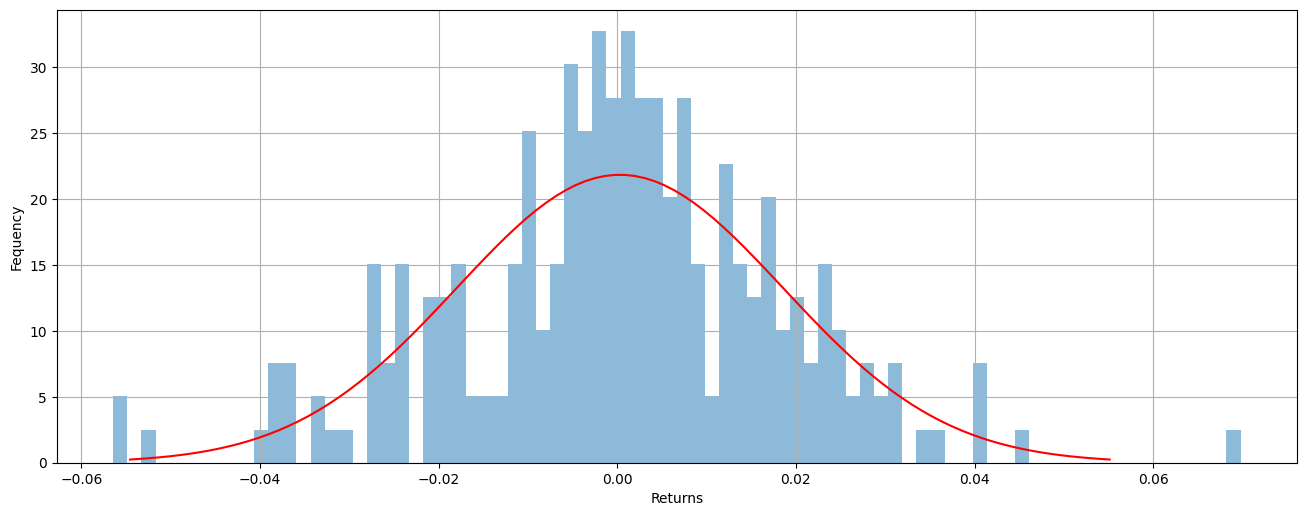

In [23]:
#@title Last year daily price movement distribution compared to normal { run: "auto" }
# ticker = yf.Ticker("VT")
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.rcParams['figure.figsize'] = [16, 6]
a=ticker.history( period='52wk', interval='1d' )[['Close']]
df=a['Close'].pct_change()
df = df.dropna()
mean = np.mean(df)
std_dev = np.std(df)
df.hist(bins=80, histtype='stepfilled', alpha=0.5, density=True,  )
x = np.linspace( mean - 3*std_dev, mean + 3*std_dev, 100)
plt.plot(x, norm.pdf(x, mean, std_dev), "r")
plt.xlabel('Returns')
plt.ylabel('Fequency')
plt.show()

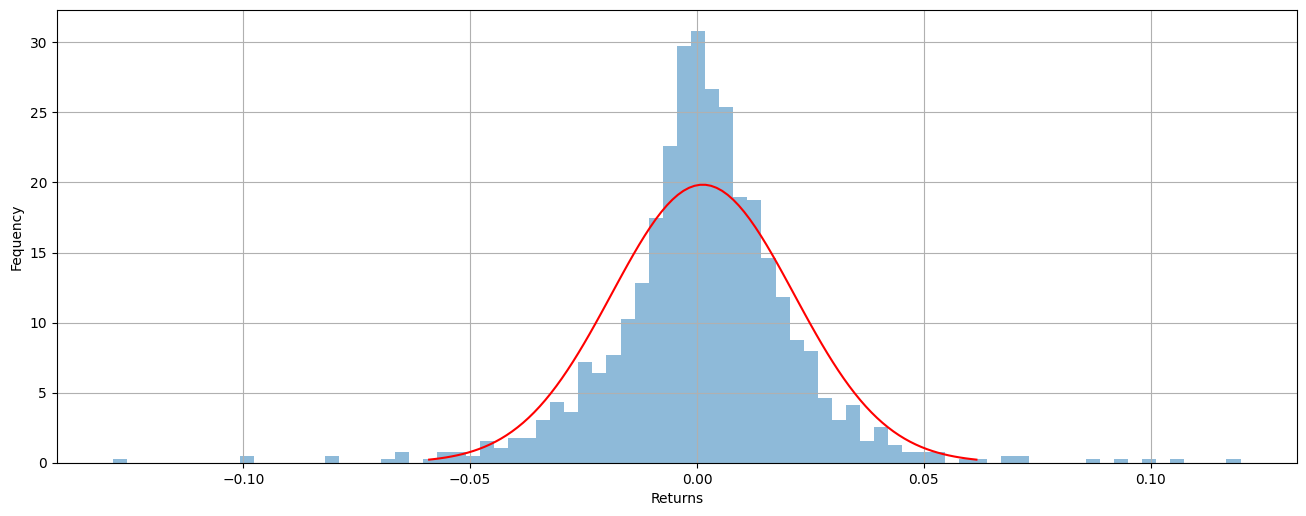

In [24]:
#@title Last 5 years daily price movement distribution compared to normal { run: "auto" }
# ticker = yf.Ticker("VT")
import matplotlib.pyplot as plt
from scipy.stats import norm
plt.rcParams['figure.figsize'] = [16, 6]
a=ticker.history( period='260wk', interval='1d' )[['Close']]
df=a['Close'].pct_change()
df = df.dropna()
mean = np.mean(df)
std_dev = np.std(df)
df.hist(bins=80, histtype='stepfilled', alpha=0.5, density=True,  )
x = np.linspace( mean - 3*std_dev, mean + 3*std_dev, 100)
plt.plot(x, norm.pdf(x, mean, std_dev), "r")
plt.xlabel('Returns')
plt.ylabel('Fequency')
plt.show()

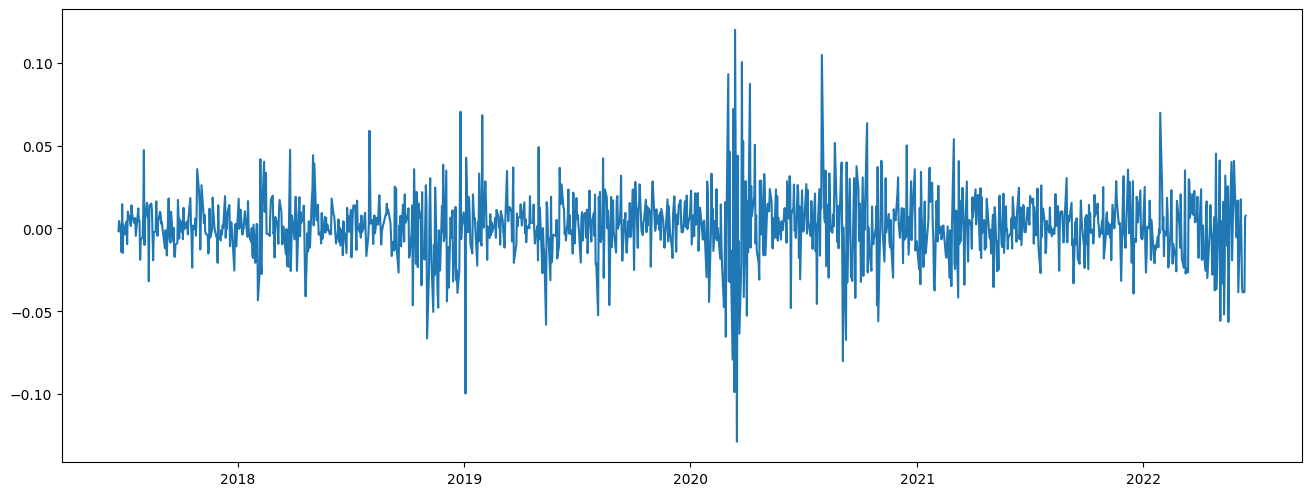

In [25]:
#@title Daily price movements { run: "auto" }
# a.mean()
# plt.plot(a.diff())
plt.plot(a.pct_change())
plt.show()

In [26]:
#@title Value at risk { run: "auto" }
VaR_90 = round(norm.ppf(1-0.9, mean, std_dev)*100,2)
VaR_95 = round(norm.ppf(1-0.95, mean, std_dev)*100,2)
VaR_99= round(norm.ppf(1-0.99, mean, std_dev)*100,2)
pd.DataFrame([['90%', str(VaR_90)+'%'], ['95%', str(VaR_95)+'%'], ["99%", str(VaR_99)+'%']], columns=['Confidence Level', 'Value at Risk'])


,Confidence Level,Value at Risk
0,90%,-2.45%
1,95%,-3.18%
2,99%,-4.55%


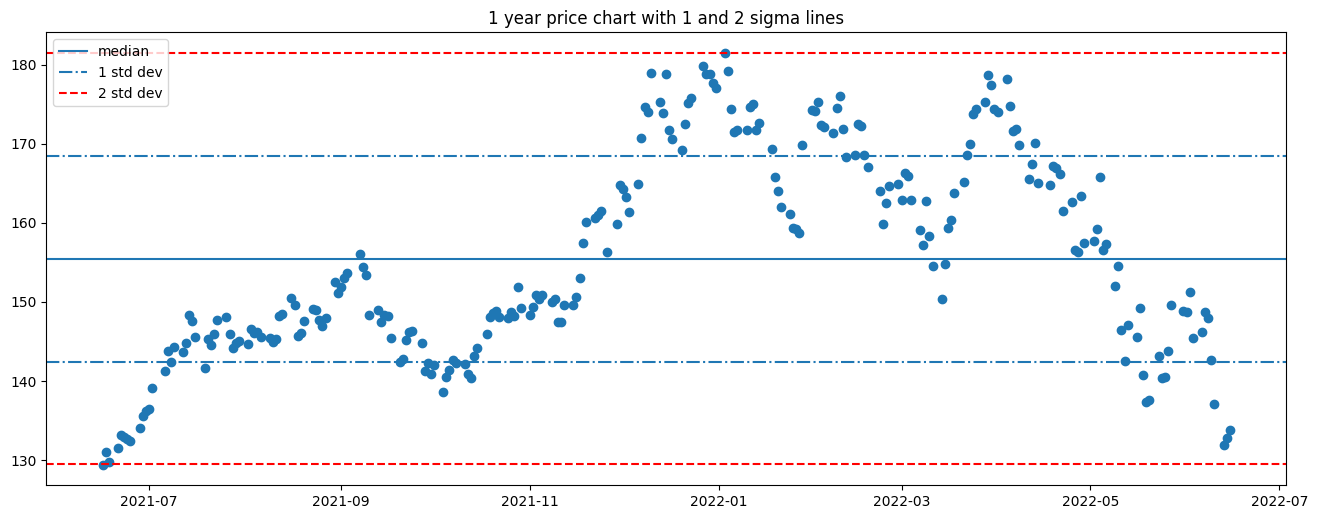

In [27]:
#@title 1 year price chart with 1 and 2 sigma lines { run: "auto" }
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# a=ticker.history( period='52wk', interval='1d' )[['High','Low']]

# ticker2 = yf.Ticker('AAPL') 
# ticker2 = yf.Ticker('TSLA') 
a=ticker.history( period='52wk', interval='1d' )[['Close']]

plt.title("1 year price chart with 1 and 2 sigma lines")
# plt.ylim(min(a['Close']) - 50, max(a['Close']) + 20)
plt.scatter(x=a.index, y=a['Close'])
# plt.scatter(x=a.index, y=a['Low'])
plt.axhline(y=a['Close'].mean(), xmin=0, xmax=1, label="median" )
# plt.axhline(y=a['Low'].mean(), xmin=0, xmax=1, color='r'  )

plt.axhline(y=a['Close'].mean()+a['Close'].std(), xmin=0, xmax=1, ls='-.', label="1 std dev" )
# plt.axhline(y=a['Low'].mean()+a['Low'].std(), xmin=0, xmax=1, color='r', ls='-.'  )
plt.axhline(y=a['Close'].mean()-a['Close'].std(), xmin=0, xmax=1, ls='-.')
# plt.axhline(y=a['Low'].mean()-a['Low'].std(), xmin=0, xmax=1, color='r', ls='-.' )

plt.axhline(y=a['Close'].mean()+2*a['Close'].std(), xmin=0, xmax=1, ls='--', color='r', label="2 std dev")
# plt.axhline(y=a['Low'].mean()+2*a['Low'].std(), xmin=0, xmax=1, color='r', ls='--' )
plt.axhline(y=a['Close'].mean()-2*a['Close'].std(), xmin=0, xmax=1, ls='--', color='r'  )
# plt.axhline(y=a['Low'].mean()-2*a['Low'].std(), xmin=0, xmax=1, color='r', ls='--'  )

# plt.axhline(y=a['Close'].mean()+3*a['Close'].std(), xmin=0, xmax=1  )
# plt.axhline(y=a['Close'].mean()-3*a['Close'].std(), xmin=0, xmax=1, color='r' )
plt.legend(loc="upper left")
plt.show()



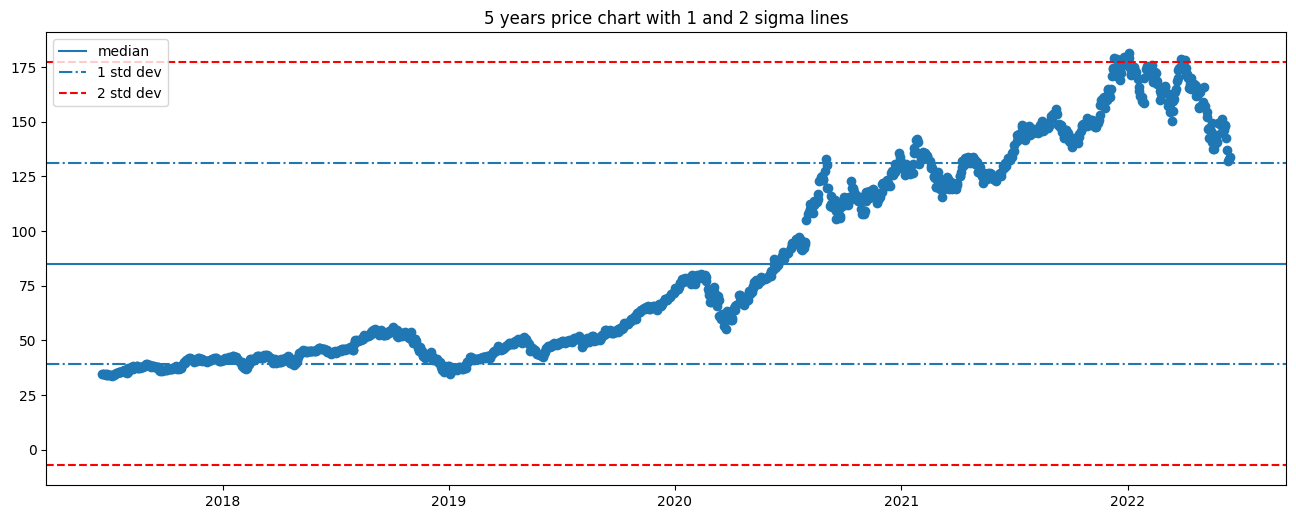

In [28]:
#@title 5 years price chart with 1 and 2 sigma lines { run: "auto" }
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 6]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
# a=ticker.history( period='52wk', interval='1d' )[['High','Low']]

# ticker2 = yf.Ticker('AAPL') 
# ticker2 = yf.Ticker('TSLA') 
a=ticker.history( period='260wk', interval='1d' )[['Close']]

plt.title("5 years price chart with 1 and 2 sigma lines")
# plt.ylim(min(a['Close']) - 50, max(a['Close']) + 20)
plt.scatter(x=a.index, y=a['Close'])
# plt.scatter(x=a.index, y=a['Low'])
plt.axhline(y=a['Close'].mean(), xmin=0, xmax=1, label="median" )
# plt.axhline(y=a['Low'].mean(), xmin=0, xmax=1, color='r'  )

plt.axhline(y=a['Close'].mean()+a['Close'].std(), xmin=0, xmax=1, ls='-.', label="1 std dev" )
# plt.axhline(y=a['Low'].mean()+a['Low'].std(), xmin=0, xmax=1, color='r', ls='-.'  )
plt.axhline(y=a['Close'].mean()-a['Close'].std(), xmin=0, xmax=1, ls='-.')
# plt.axhline(y=a['Low'].mean()-a['Low'].std(), xmin=0, xmax=1, color='r', ls='-.' )

plt.axhline(y=a['Close'].mean()+2*a['Close'].std(), xmin=0, xmax=1, ls='--', color='r', label="2 std dev")
# plt.axhline(y=a['Low'].mean()+2*a['Low'].std(), xmin=0, xmax=1, color='r', ls='--' )
plt.axhline(y=a['Close'].mean()-2*a['Close'].std(), xmin=0, xmax=1, ls='--', color='r'  )
# plt.axhline(y=a['Low'].mean()-2*a['Low'].std(), xmin=0, xmax=1, color='r', ls='--'  )

# plt.axhline(y=a['Close'].mean()+3*a['Close'].std(), xmin=0, xmax=1  )
# plt.axhline(y=a['Close'].mean()-3*a['Close'].std(), xmin=0, xmax=1, color='r' )
plt.legend(loc="upper left")
plt.show()



In [30]:
#@title Dividends	and Stock Splits
ticker.actions

,Dividends,Stock Splits
Date,,
2017-08-10,0.1575,0.0
2017-11-10,0.1575,0.0
2018-02-09,0.1575,0.0
2018-05-11,0.1825,0.0
2018-08-10,0.1825,0.0
2018-11-08,0.1825,0.0
2019-02-08,0.1825,0.0
2019-05-10,0.1925,0.0
2019-08-09,0.1925,0.0


In [29]:
#@title Print option chain { run: "auto" }
nearOdate=ticker.options[0]
date = "" 
 # @ param {type:"string"}
opt = ticker.option_chain(date or nearOdate)
# opts=opt[0]
# hf=int(len(opts)/2)
# inM=opts.loc[opts['inTheMoney'] ] # == True
# inMndx=opts.loc[opts['inTheMoney'] == True].index[0] 
# if inMndx<=distanceStrike:
  # distanceStrike = inMndx
# df1=opts.iloc[inMndx-distanceStrike:inMndx+distanceStrike].style.hide_index()
# df1.set_table_styles( [{'selector': 'tr:hover',   'props': [('background-color', 'yellow')]}] )
# opts.style.background_gradient()
# opts.round(2)
# pp=opts.round({"strike":1, "lastPrice":2, "bid":3, "ask":4})
# data_table.DataTable(opts[['strike','lastPrice','impliedVolatility','inTheMoney']].round(2), 
#                      include_index=False, num_rows_per_page=200  ) # , min_width="500"
print(f'Exp date: {nearOdate}')
print('Calls')
display(data_table.DataTable(opt[0].round(2), include_index=False, num_rows_per_page=200  )) # , min_width="500"
print(f'Exp date: {nearOdate}')
print('Puts')
display(data_table.DataTable(opt[1].round(2), include_index=False, num_rows_per_page=200  )) # , min_width="500"

# .style.hide_index().background_gradient(cmap='coolwarm', subset='impliedVolatility')


Exp date: 2022-06-17
Calls


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL220617C00028750,2022-06-10 17:49:25+00:00,28.75,109.70,105.55,105.75,0.00,0.00,1,16,9.24,True,REGULAR,USD
1,AAPL220617C00030000,2022-06-10 17:49:25+00:00,30.00,108.45,104.15,104.35,0.00,0.00,1,6,8.58,True,REGULAR,USD
2,AAPL220617C00031250,2022-06-10 13:59:59+00:00,31.25,107.15,102.90,103.05,0.00,0.00,1,1,8.28,True,REGULAR,USD
3,AAPL220617C00032500,2022-06-03 15:10:12+00:00,32.50,112.40,101.65,101.85,0.00,0.00,1,35,8.13,True,REGULAR,USD
4,AAPL220617C00033750,2022-06-07 18:43:00+00:00,33.75,114.75,100.40,100.65,0.00,0.00,1,12,7.99,True,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150,AAPL220617C00680000,2020-08-27 16:59:15+00:00,680.00,333.83,329.00,334.00,283.63,565.00,30,146,0.00,False,REGULAR,USD
151,AAPL220617C00700000,2020-08-28 19:12:54+00:00,700.00,1125.00,324.00,329.00,1079.20,2356.33,127,52,0.00,False,REGULAR,USD
152,AAPL220617C00720000,2020-08-28 16:29:09+00:00,720.00,1106.80,319.50,324.50,1063.55,2459.08,1,362,0.00,False,REGULAR,USD
153,AAPL220617C00740000,2020-08-28 17:46:32+00:00,740.00,932.00,315.00,320.00,891.00,2173.17,7,78,0.00,False,REGULAR,USD


Exp date: 2022-06-17
Puts


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
0,AAPL220617P00028750,2022-06-15 14:17:40+00:00,28.75,0.01,0.00,0.01,0.00,0.00,3.0,1645.0,5.25,False,REGULAR,USD
1,AAPL220617P00030000,2022-06-13 14:21:52+00:00,30.00,0.01,0.00,0.01,0.00,0.00,2.0,2813.0,5.13,False,REGULAR,USD
2,AAPL220617P00031250,2022-02-08 14:30:04+00:00,31.25,0.02,0.00,0.06,0.00,0.00,2.0,440.0,5.84,False,REGULAR,USD
3,AAPL220617P00032500,2022-03-22 15:12:03+00:00,32.50,0.02,0.00,0.02,0.00,0.00,1.0,514.0,5.13,False,REGULAR,USD
4,AAPL220617P00033750,2022-05-12 16:05:32+00:00,33.75,0.01,0.00,0.05,0.00,0.00,20.0,394.0,5.44,False,REGULAR,USD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,AAPL220617P00600000,2020-08-27 16:53:15+00:00,600.00,170.00,166.65,169.80,0.00,0.00,NaN,2.0,0.00,True,REGULAR,USD
143,AAPL220617P00640000,2020-08-07 14:08:26+00:00,640.00,218.72,196.65,200.10,0.00,0.00,1.0,1.0,0.00,True,REGULAR,USD
144,AAPL220617P00700000,2020-08-24 18:56:07+00:00,700.00,18.60,4.55,4.80,-222.86,-92.30,4.0,413.0,0.00,True,REGULAR,USD
145,AAPL220617P00720000,2020-08-24 18:56:07+00:00,720.00,5.06,4.90,5.20,-253.00,-98.04,2.0,669.0,0.00,True,REGULAR,USD
